# Model Evaluation & Comparison

## Evaluation Metrics:
- **Balanced Accuracy** (PRIMARY METRIC for imbalanced data)
- Per-class Precision, Recall, F1-Score
- Confusion Matrix
- Overall Accuracy

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, balanced_accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
BASE_DIR = r'D:\Projects\MulticlassFishImageClassification\data'
TEST_DIR = os.path.join(BASE_DIR, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 11

CLASS_NAMES = [
    'animal fish',
    'animal fish bass',
    'fish sea_food black_sea_sprat',
    'fish sea_food gilt_head_bream',
    'fish sea_food hourse_mackerel',
    'fish sea_food red_mullet',
    'fish sea_food red_sea_bream',
    'fish sea_food sea_bass',
    'fish sea_food shrimp',
    'fish sea_food striped_red_mullet',
    'fish sea_food trout'
]

print("Configuration loaded")

Configuration loaded


In [3]:
# Focal Loss (needed for loading models)
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"est generator created: {test_gen.samples} samples")

Found 3187 images belonging to 11 classes.
est generator created: 3187 samples


## 1. Load All Models

In [5]:
# Model names
MODEL_NAMES = [
    'CustomCNN',
    'VGG16',
    'ResNet50',
    'MobileNet',
    'InceptionV3',
    'EfficientNetV2B0'
]

# Load models
models = {}
for model_name in MODEL_NAMES:
    try:
        model_path = f'models/{model_name}_best.h5'
        model = load_model(model_path, custom_objects={'focal_loss_fixed': focal_loss()})
        models[model_name] = model
        print(f"✓ Loaded {model_name}")
    except Exception as e:
        print(f"✗ Failed to load {model_name}: {e}")

print(f"\n✓ Successfully loaded {len(models)} models")

✓ Loaded CustomCNN


✓ Loaded VGG16


✓ Loaded ResNet50


✓ Loaded MobileNet


✓ Loaded InceptionV3


✓ Loaded EfficientNetV2B0

✓ Successfully loaded 6 models


## 2. Evaluate Each Model

In [6]:
def evaluate_model(model, model_name, generator):
    print(f"\n{'='*80}")
    print(f"EVALUATING: {model_name}")
    print(f"{'='*80}")
    
    # Get predictions
    generator.reset()
    y_pred_probs = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = generator.classes
    
    # Overall accuracy
    overall_acc = accuracy_score(y_true, y_pred)
    
    # Balanced accuracy (MOST IMPORTANT for imbalanced data!)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(NUM_CLASSES)
    )
    
    # Classification report
    class_report = classification_report(
        y_true, y_pred, target_names=CLASS_NAMES, digits=3
    )
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\nOVERALL METRICS:")
    print(f"  Overall Accuracy: {overall_acc:.4f} (can be misleading with imbalance!)")
    print(f"  Balanced Accuracy: {balanced_acc:.4f}(PRIMARY METRIC)")
    
    print(f"\nPER-CLASS METRICS:")
    print(class_report)
    
    return {
        'model_name': model_name,
        'overall_accuracy': overall_acc,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred
    }

# Evaluate all models
evaluation_results = {}
for model_name, model in models.items():
    results = evaluate_model(model, model_name, test_gen)
    evaluation_results[model_name] = results

print("All models evaluated!")


EVALUATING: CustomCNN
200/200 ━━━━━━━━━━━━━━━━━━━━ 88s 435ms/step

OVERALL METRICS:
  Overall Accuracy: 0.8858 (can be misleading with imbalance!)
  Balanced Accuracy: 0.8112(PRIMARY METRIC)

PER-CLASS METRICS:
                                  precision    recall  f1-score   support

                     animal fish      0.967     0.965     0.966       520
                animal fish bass      0.059     0.077     0.067        13
   fish sea_food black_sea_sprat      0.782     0.990     0.874       298
   fish sea_food gilt_head_bream      0.854     0.577     0.689       305
   fish sea_food hourse_mackerel      0.979     0.811     0.887       286
        fish sea_food red_mullet      0.976     0.966     0.971       291
     fish sea_food red_sea_bream      0.771     0.886     0.825       273
          fish sea_food sea_bass      0.788     0.853     0.819       327
            fish sea_food shrimp      0.954     0.938     0.946       289
fish sea_food striped_red_mullet      0.921    

## 3. Compare Models

In [7]:
# Create comparison DataFrame
comparison_data = []
for model_name, results in evaluation_results.items():
    comparison_data.append({
        'Model': model_name,
        'Overall Accuracy': results['overall_accuracy'],
        'Balanced Accuracy': results['balanced_accuracy'],
        'Avg Precision': results['precision'].mean(),
        'Avg Recall': results['recall'].mean(),
        'Avg F1-Score': results['f1'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Balanced Accuracy', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON (Sorted by Balanced Accuracy)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_balanced_acc = comparison_df.iloc[0]['Balanced Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Balanced Accuracy: {best_balanced_acc:.4f}")
print("="*100)

# Save comparison
comparison_df.to_csv('results/metrics/model_comparison.csv', index=False)
print("Comparison saved to results/metrics/model_comparison.csv")


MODEL COMPARISON (Sorted by Balanced Accuracy)
           Model  Overall Accuracy  Balanced Accuracy  Avg Precision  Avg Recall  Avg F1-Score
       MobileNet          0.989332           0.989499       0.989665    0.989499      0.989483
     InceptionV3          0.945717           0.921917       0.917769    0.921917      0.918648
           VGG16          0.896768           0.813655       0.812071    0.813655      0.811824
       CustomCNN          0.885786           0.811229       0.815595    0.811229      0.808370
        ResNet50          0.261061           0.209054       0.182477    0.209054      0.144240
EfficientNetV2B0          0.163163           0.090909       0.014833    0.090909      0.025505

🏆 BEST MODEL: MobileNet
   Balanced Accuracy: 0.9895
Comparison saved to results/metrics/model_comparison.csv


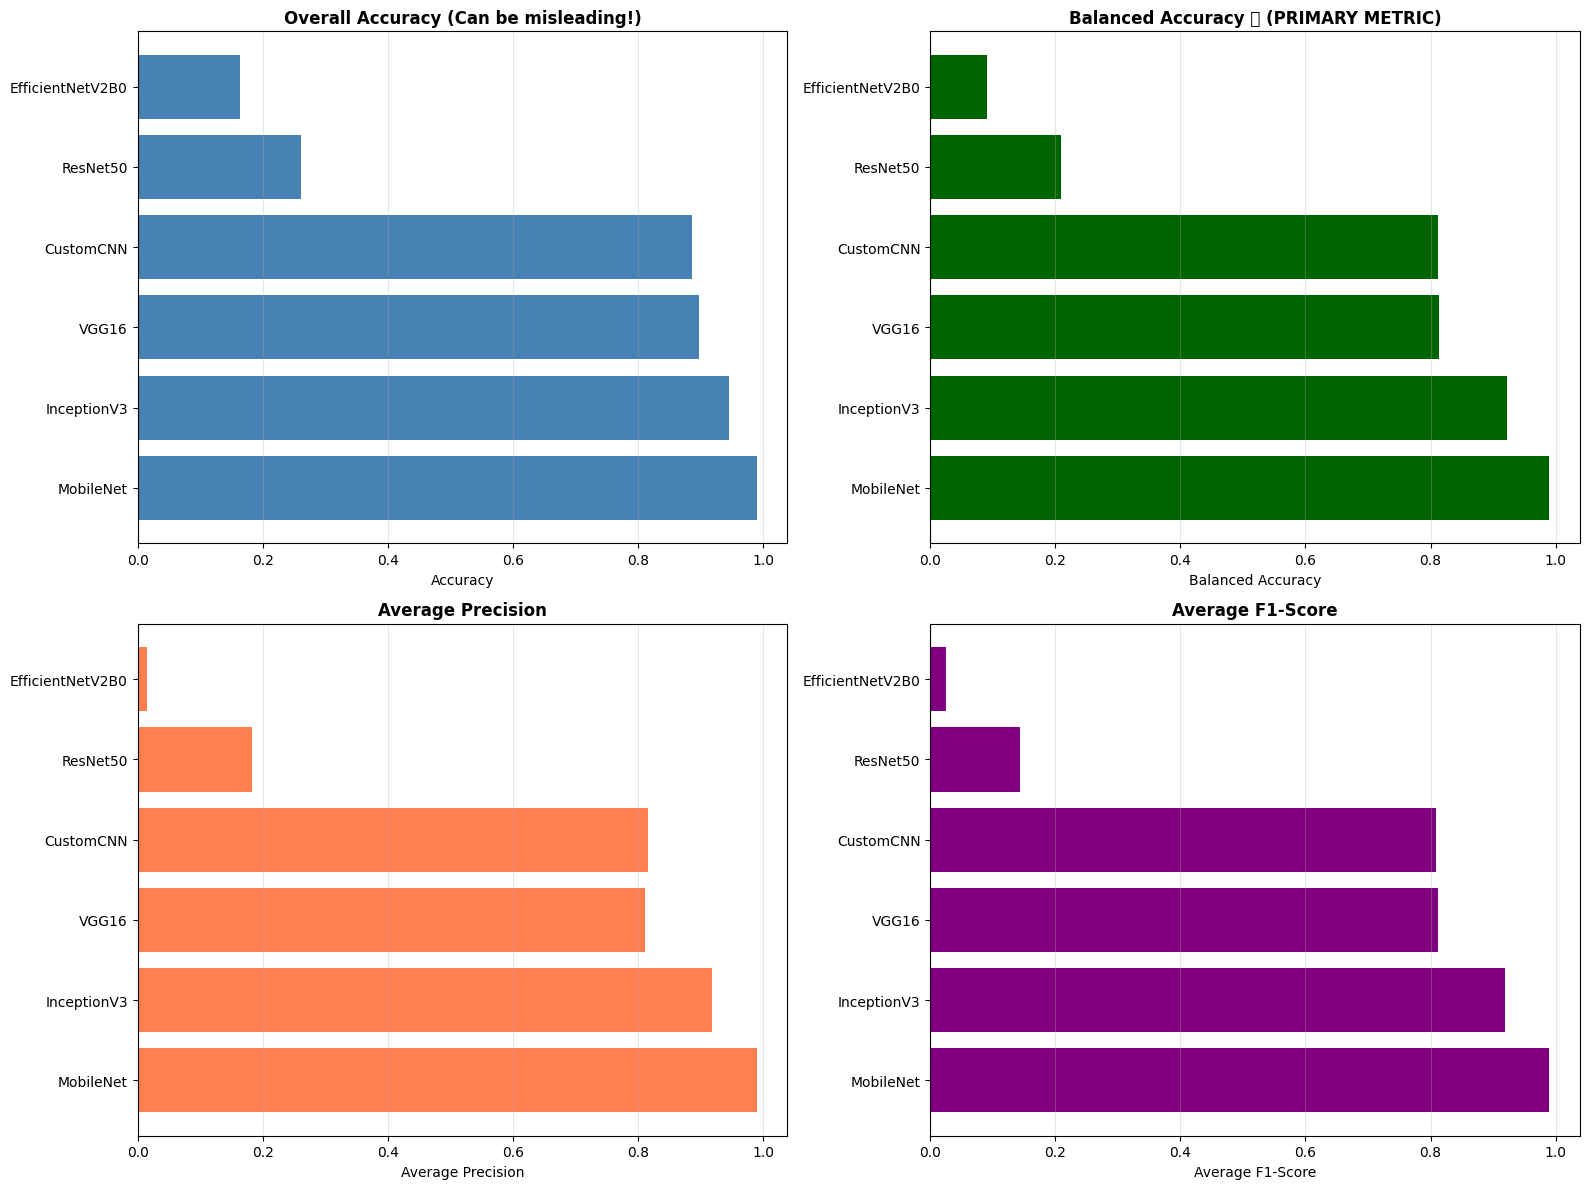

✓ Comparison plot saved


In [8]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall Accuracy
axes[0, 0].barh(comparison_df['Model'], comparison_df['Overall Accuracy'], color='steelblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Overall Accuracy (Can be misleading!)', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Balanced Accuracy
axes[0, 1].barh(comparison_df['Model'], comparison_df['Balanced Accuracy'], color='darkgreen')
axes[0, 1].set_xlabel('Balanced Accuracy')
axes[0, 1].set_title('Balanced Accuracy ⭐ (PRIMARY METRIC)', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Precision
axes[1, 0].barh(comparison_df['Model'], comparison_df['Avg Precision'], color='coral')
axes[1, 0].set_xlabel('Average Precision')
axes[1, 0].set_title('Average Precision', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# F1-Score
axes[1, 1].barh(comparison_df['Model'], comparison_df['Avg F1-Score'], color='purple')
axes[1, 1].set_xlabel('Average F1-Score')
axes[1, 1].set_title('Average F1-Score', fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved")

## 4. Per-Class Performance Analysis

In [9]:
# Analyze per-class performance for best model
best_results = evaluation_results[best_model_name]

per_class_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': best_results['precision'],
    'Recall': best_results['recall'],
    'F1-Score': best_results['f1'],
    'Support': best_results['support']
})

# Sort by support (to see minority classes)
per_class_df = per_class_df.sort_values('Support', ascending=True)

print(f"\n{'='*100}")
print(f"PER-CLASS PERFORMANCE: {best_model_name}")
print(f"{'='*100}")
print(per_class_df.to_string(index=False))
print(f"{'='*100}")

# Identify problematic classes
print("\n⚠️  CLASSES WITH LOW PERFORMANCE:")
low_perf = per_class_df[per_class_df['F1-Score'] < 0.7]
if len(low_perf) > 0:
    print(low_perf.to_string(index=False))
else:
    print("All classes performing well! (F1 > 0.7)")

# Save per-class metrics
per_class_df.to_csv(f'results/metrics/{best_model_name}_per_class_metrics.csv', index=False)
print(f"\n✓ Per-class metrics saved")


PER-CLASS PERFORMANCE: MobileNet
                           Class  Precision   Recall  F1-Score  Support
                animal fish bass   1.000000 1.000000  1.000000       13
     fish sea_food red_sea_bream   1.000000 0.989011  0.994475      273
   fish sea_food hourse_mackerel   0.969283 0.993007  0.981002      286
            fish sea_food shrimp   1.000000 1.000000  1.000000      289
        fish sea_food red_mullet   0.996364 0.941581  0.968198      291
             fish sea_food trout   1.000000 1.000000  1.000000      292
fish sea_food striped_red_mullet   0.952862 0.965870  0.959322      293
   fish sea_food black_sea_sprat   0.990033 1.000000  0.994992      298
   fish sea_food gilt_head_bream   0.983871 1.000000  0.991870      305
          fish sea_food sea_bass   0.993902 0.996942  0.995420      327
                     animal fish   1.000000 0.998077  0.999038      520

⚠️  CLASSES WITH LOW PERFORMANCE:
All classes performing well! (F1 > 0.7)

✓ Per-class metrics saved


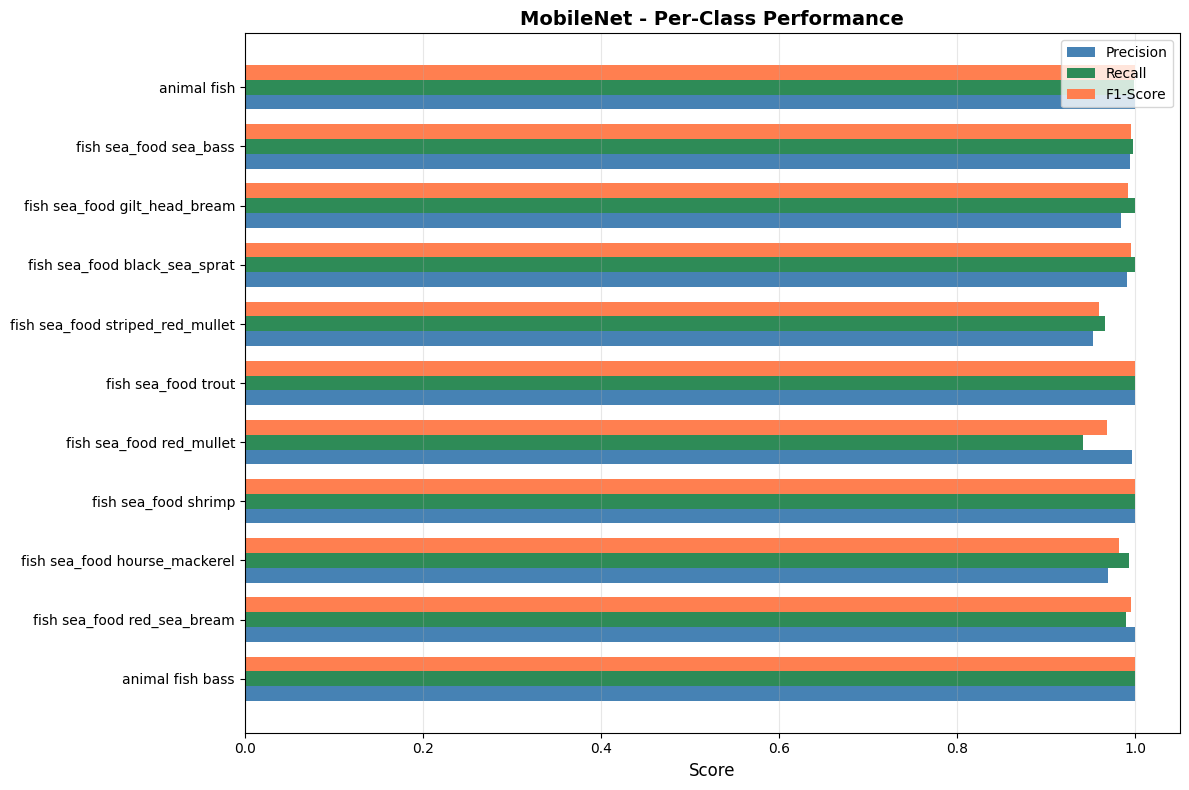

✓ Per-class performance plot saved


In [10]:
# Visualize per-class performance
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(per_class_df))
width = 0.25

ax.barh(x - width, per_class_df['Precision'], width, label='Precision', color='steelblue')
ax.barh(x, per_class_df['Recall'], width, label='Recall', color='seagreen')
ax.barh(x + width, per_class_df['F1-Score'], width, label='F1-Score', color='coral')

ax.set_yticks(x)
ax.set_yticklabels(per_class_df['Class'], fontsize=10)
ax.set_xlabel('Score', fontsize=12)
ax.set_title(f'{best_model_name} - Per-Class Performance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(f'results/plots/{best_model_name}_per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Per-class performance plot saved")

## 5. Confusion Matrices

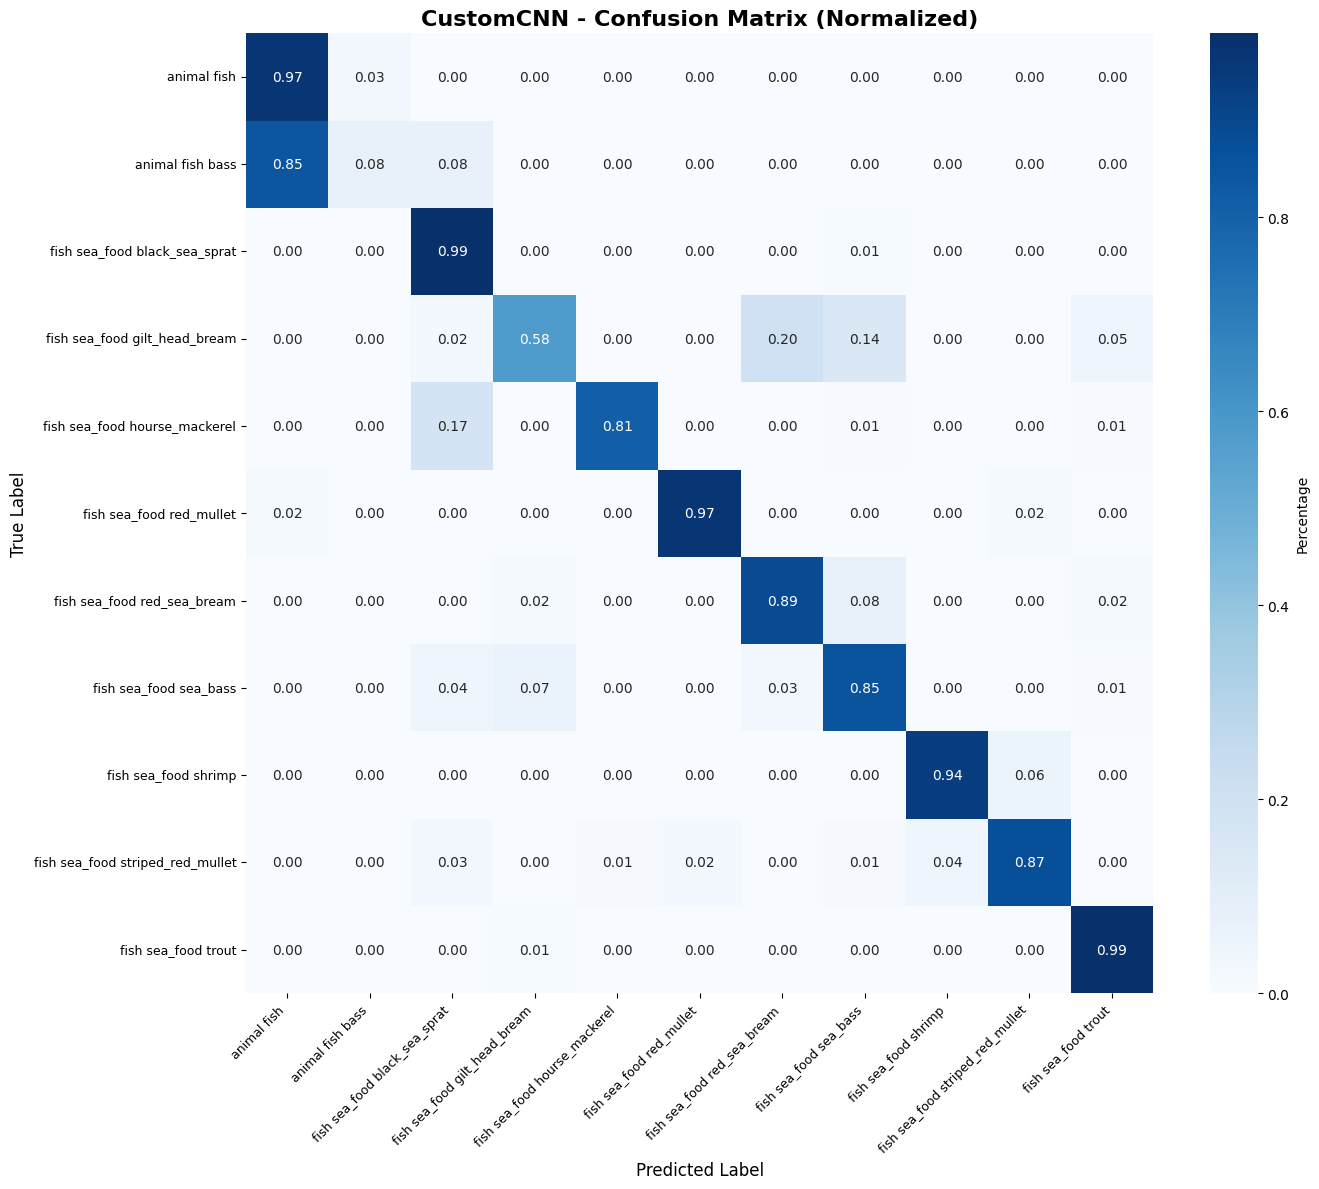

✓ Confusion matrix for CustomCNN saved


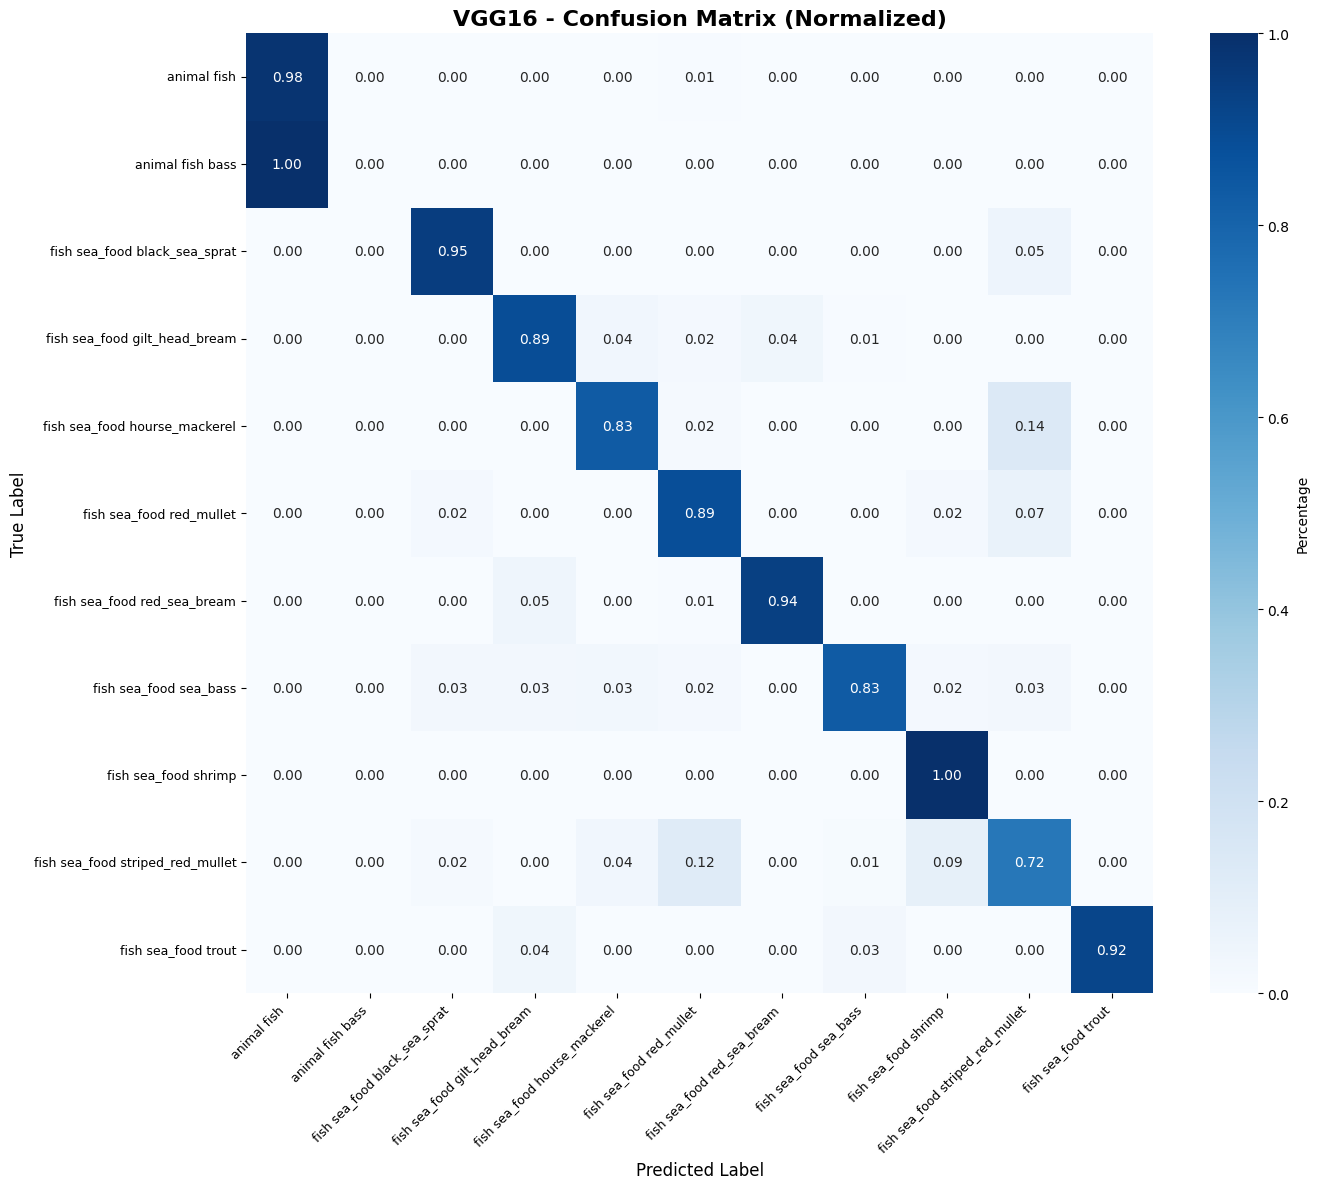

✓ Confusion matrix for VGG16 saved


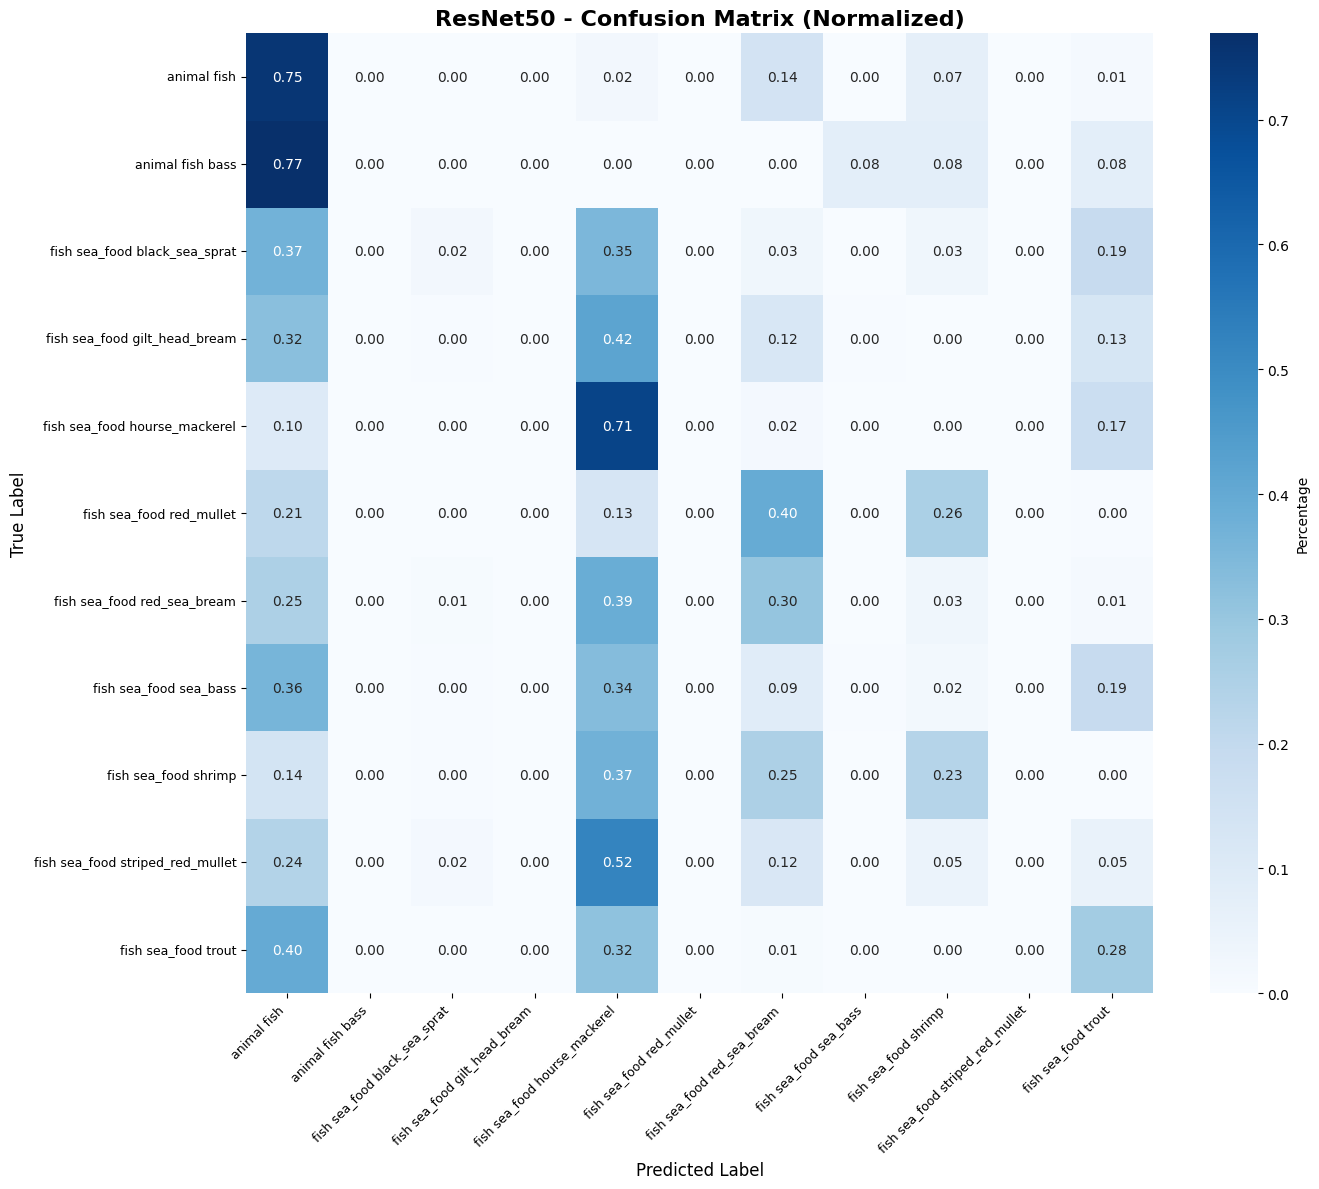

✓ Confusion matrix for ResNet50 saved


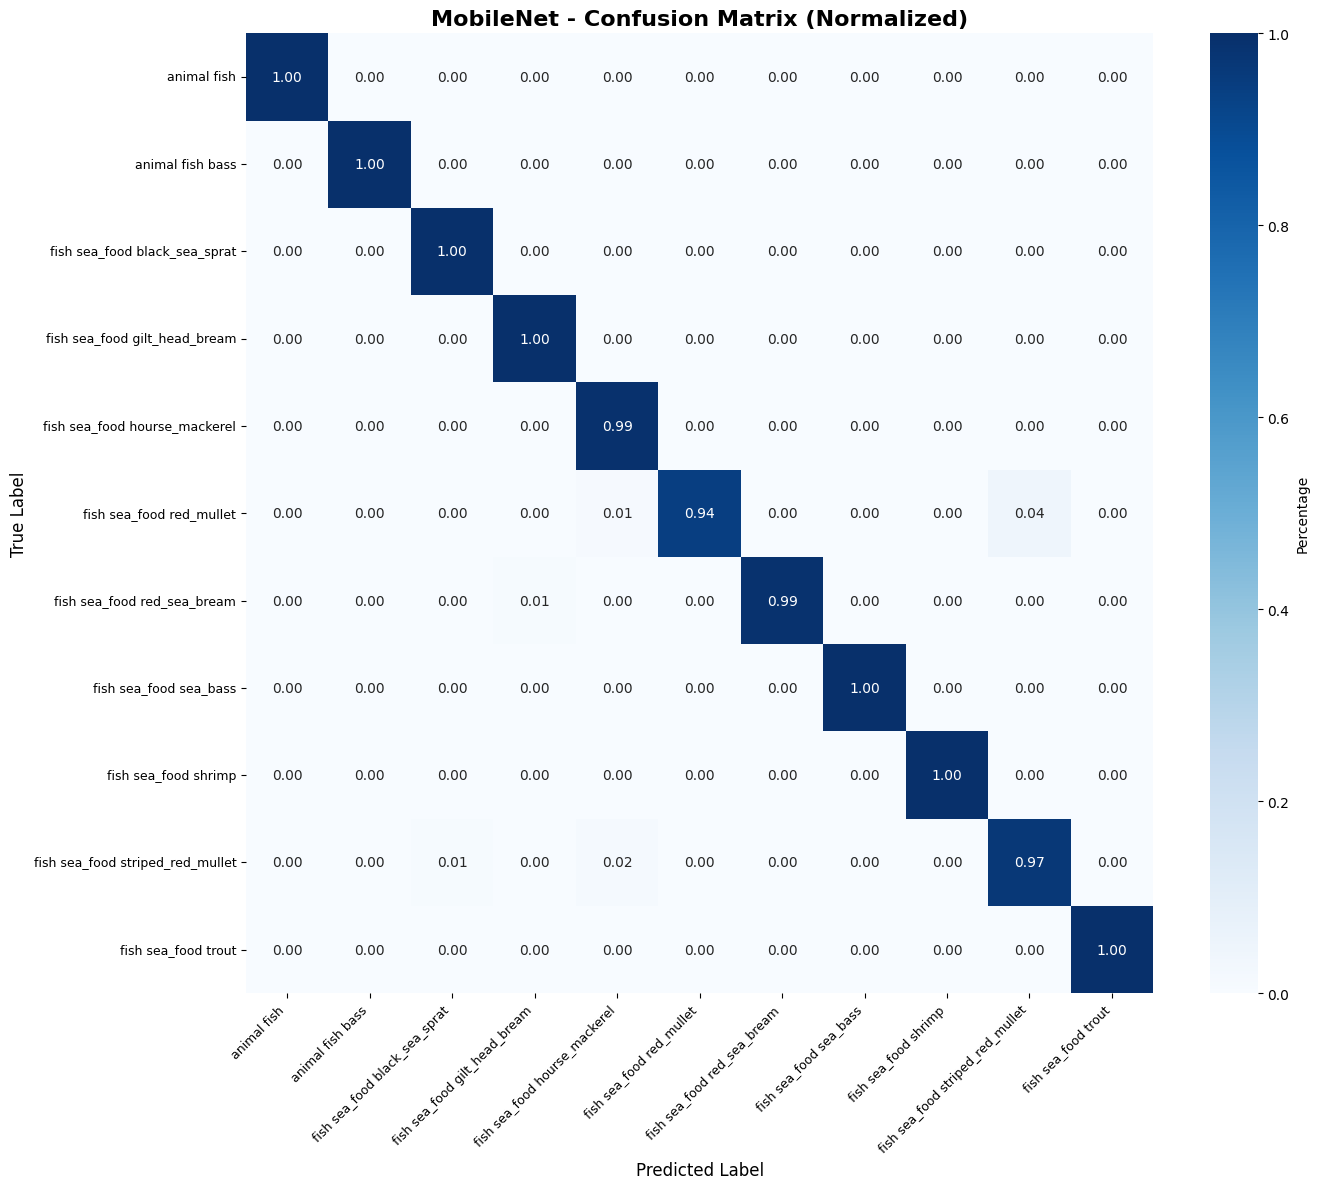

✓ Confusion matrix for MobileNet saved


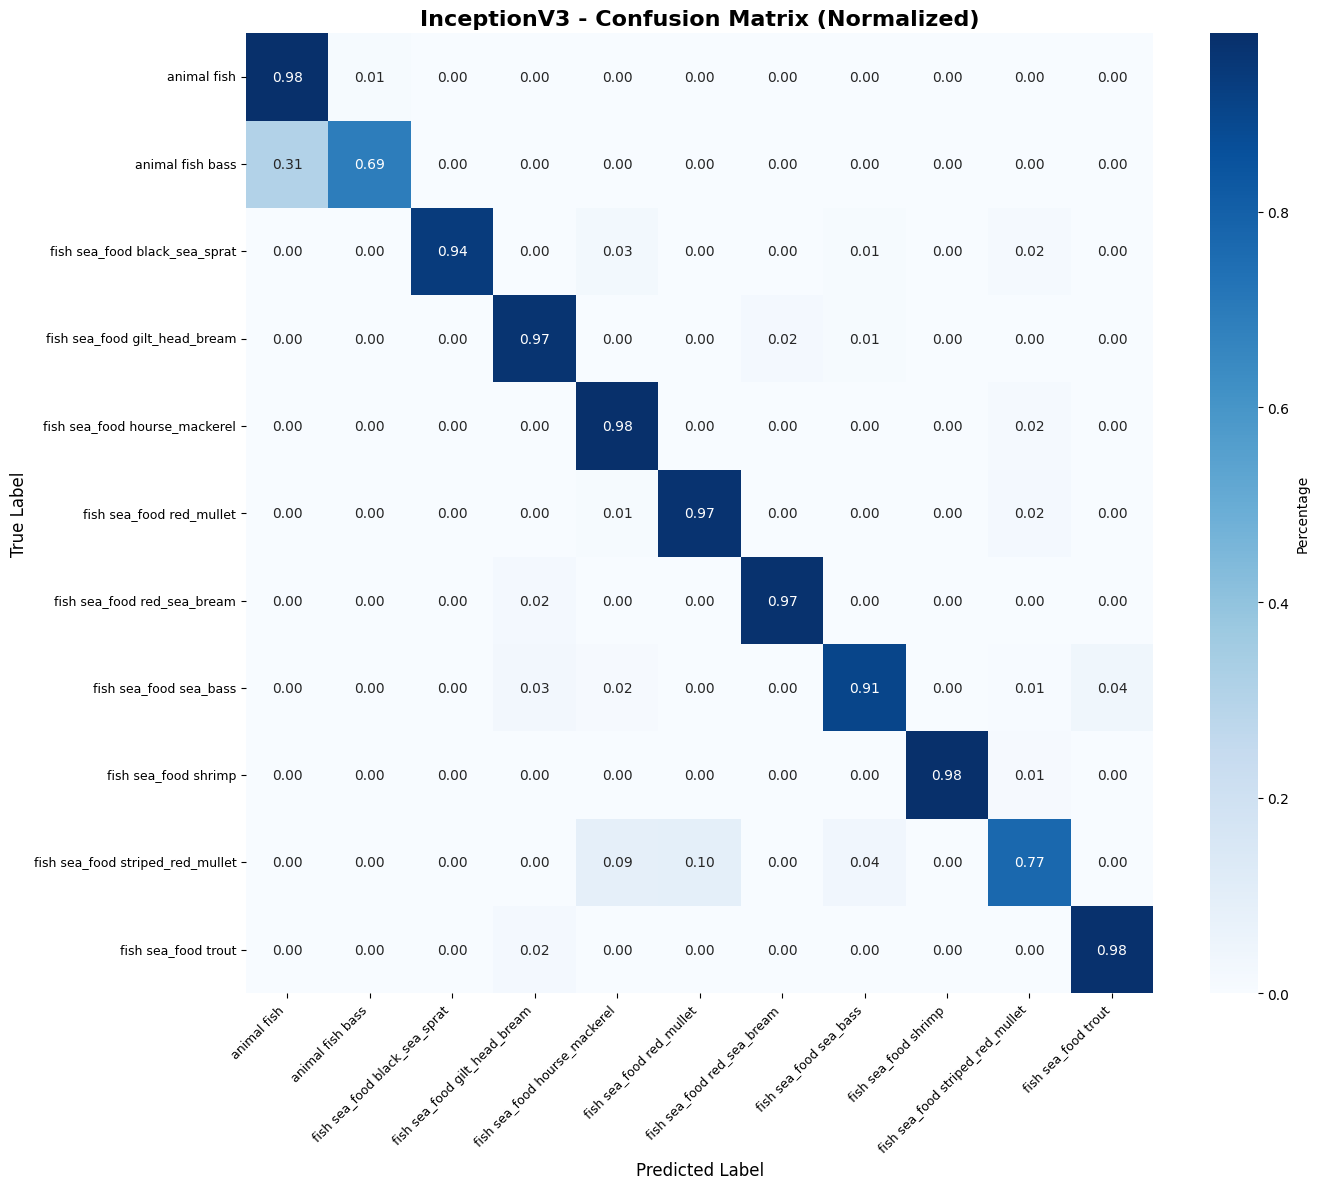

✓ Confusion matrix for InceptionV3 saved


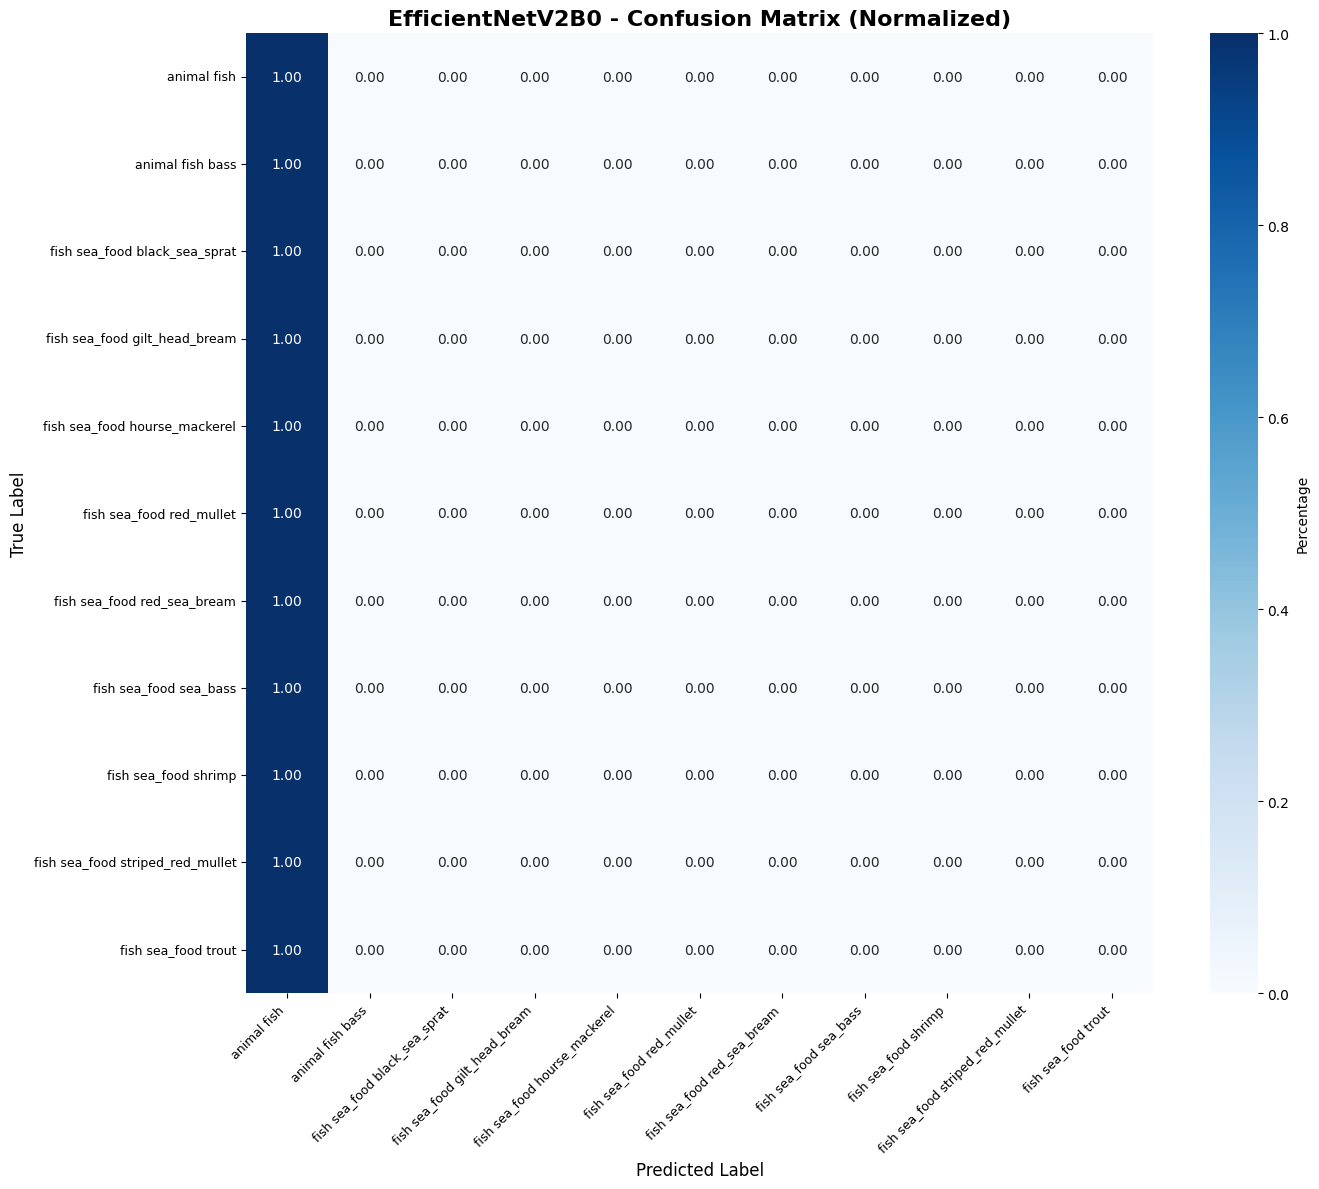

✓ Confusion matrix for EfficientNetV2B0 saved

✓ All confusion matrices saved to results/confusion_matrices/


In [11]:
def plot_confusion_matrix(cm, model_name, class_names):
    """
    Plot confusion matrix with percentages
    """
    plt.figure(figsize=(14, 12))
    
    # Normalize by row (actual labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    
    plt.title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(f'results/confusion_matrices/{model_name}_confusion_matrix.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrix for each model
for model_name, results in evaluation_results.items():
    plot_confusion_matrix(results['confusion_matrix'], model_name, CLASS_NAMES)
    print(f"✓ Confusion matrix for {model_name} saved")

print("\n✓ All confusion matrices saved to results/confusion_matrices/")

## 6. Save Best Model for Deployment

In [12]:
# Copy best model to deployment folder
import shutil

best_model_path = f'models/{best_model_name}_best.h5'
deployment_path = 'models/BEST_MODEL_FOR_DEPLOYMENT.h5'

shutil.copy(best_model_path, deployment_path)

print(f"\n{'='*80}")
print("BEST MODEL FOR DEPLOYMENT")
print(f"{'='*80}")
print(f"Model: {best_model_name}")
print(f"Balanced Accuracy: {best_balanced_acc:.4f}")
print(f"Saved to: {deployment_path}")
print(f"{'='*80}")

# Save model metadata
import json
metadata = {
    'model_name': best_model_name,
    'balanced_accuracy': float(best_balanced_acc),
    'overall_accuracy': float(evaluation_results[best_model_name]['overall_accuracy']),
    'class_names': CLASS_NAMES,
    'img_size': IMG_SIZE
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("✓ Model metadata saved to models/model_metadata.json")


BEST MODEL FOR DEPLOYMENT
Model: MobileNet
Balanced Accuracy: 0.9895
Saved to: models/BEST_MODEL_FOR_DEPLOYMENT.h5
✓ Model metadata saved to models/model_metadata.json


## Summary

### Evaluation Completed

✅ All models evaluated on test set
✅ Balanced Accuracy used as primary metric (handles class imbalance)
✅ Per-class performance analyzed
✅ Confusion matrices generated
